<a href="https://colab.research.google.com/github/benwtks/machine-learning/blob/master/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats as stats

import seaborn as sns
#sns.set()
sns.set(color_codes=True)

# Gaussian distribution and Probability Density Funcs (PDFs)

In the first lab we used a normal distribution, let's look at plotting a normal distribution's PDF. Remember the normal (Gaussian) distribution is defined as

$$p(x; \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right).$$

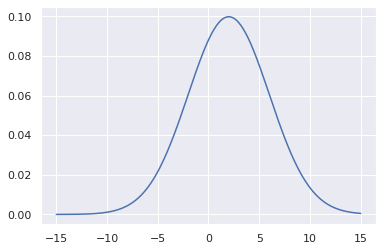

In [ ]:
def gaussian(x, mean, stdev):
    return np.exp(-((x-mean)**2)/(2*stdev**2))/(np.sqrt(2*np.pi)*stdev)

x = np.linspace(-15, 15, 250)
plt.plot(x, gaussian(x, 2, 4))

Text(0.5, 1.0, 'Area under the curve gives probability -- here 90% probability limits')

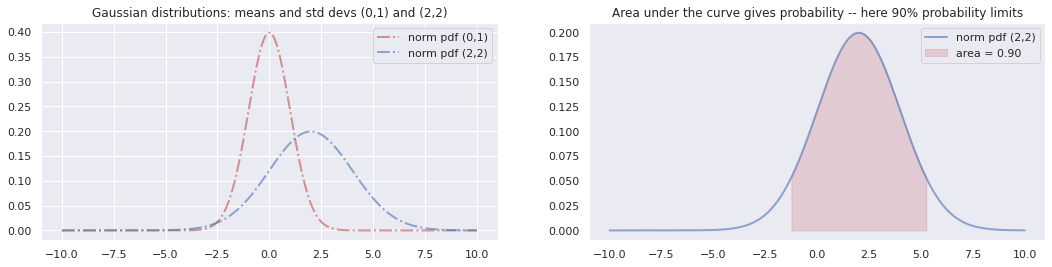

In [ ]:
# create grid of 150 points from -3, 5
x = np.linspace(-10, 10, 250)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
ax[0].plot(x, stats.norm.pdf(x), 'r-.', lw=2, alpha=0.6, label='norm pdf (0,1)')
ax[0].plot(x, stats.norm.pdf(x, 2, 2), 'b-.', lw=2, alpha=0.6, label='norm pdf (2,2)')
ax[0].legend()
ax[0].set_title("Gaussian distributions: means and std devs (0,1) and (2,2)")
x_90_idx = (x > stats.norm.ppf(0.05, 2, 2)) & (x < stats.norm.ppf(0.95, 2, 2))
ax[1].grid(False)
ax[1].plot(x, stats.norm.pdf(x, 2, 2), 'b-', lw=2, alpha=0.6,  label='norm pdf (2,2)')
ax[1].fill_between(x[x_90_idx], stats.norm.pdf(x[x_90_idx], 2, 2), color='r', alpha=.2, label='area = 0.90')
ax[1].legend()
ax[1].set_title("Area under the curve gives probability -- here 90% probability limits")

# Cumulative distribution functions (CDFs)

$$\mbox{cdf}(x) = \int_{-\infty}^x \mbox{pdf}(x') dx'.$$

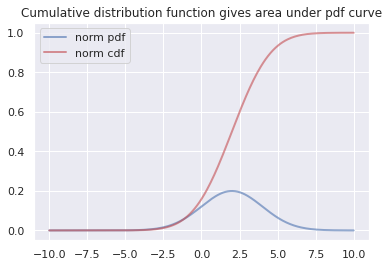

In [ ]:
plt.plot(x, stats.norm.pdf(x, 2, 2), 'b-', lw=2, alpha=0.6, label='norm pdf')
plt.plot(x, stats.norm.cdf(x, 2, 2), 'r-', lw=2, alpha=0.6, label='norm cdf')
plt.title("Cumulative distribution function gives area under pdf curve")
plt.legend()

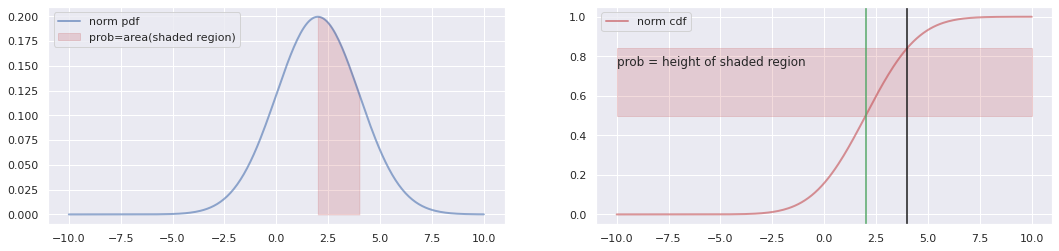

In [ ]:
fix, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
x1 = np.linspace(2, 4, 50) # want to graphically 
ax[0].plot(x, stats.norm.pdf(x, 2, 2), 'b-', lw=2, alpha=0.6, label='norm pdf')
ax[0].fill_between(x1, stats.norm.pdf(x1, 2, 2), color='r', alpha=.2, label='prob=area(shaded region)')
ax[0].legend()


ax[1].plot(x, stats.norm.cdf(x, 2, 2), 'r-', lw=2, alpha=0.6, label='norm cdf')
ax[1].axvline(2, color = 'g')
ax[1].axvline(4, color = 'k')
ax[1].text(-10,.75,"prob = height of shaded region")

ax[1].fill_between(x, y_2, y_4, color='r', alpha=0.2)
ax[1].legend()

# Linear regression

In order to perform linear regression, we could look at applying a gaussian distribution. What is the probability of observing a data point such as the winning time of a 100m sprint for a particular year? We propose a model that, given an input year  $x_{n}$  produces an output time  $y^{n}$  using a model: $$y = f(x; \mathbf{w}) = f(x; w_0, w_1)$$

Once you have decided on a model parameterised by  $w=(w_{0},w_{1})$  (intercept, slope) of a straight line, your belief in observing a given data point  tn  (finish time of sprint) is high if you have chosen good values of  $w_{0}$  and  $w_{1}$

For any choice of  $w_{0}$  and  $w_{1}$  you can evaluate $$p(t_n \quad|\quad f(x_n; w_0, w_1)) = p(t_n \quad|\quad  w_0 + w_1 x_n)$$ the conditional probability of seeing the observed data pair $(x_n, t_n)$

Each data point $(x_n, t_n), n=1, \ldots, N$ is chosen *independently* (remember taking $x_n$ as our x and $t_n$ as our actual data point)

The joint probability of two random variables $C$ and $D$ stores the probability of jointly observing values $C=c$ and $D=d$ and is denoted $P(C=c, D=d)$. If the two variables $C$ and $D$ are independent $P(C=c, D=d) = P(C=c) P(D=d)$

The joint probability of observing the data-set $D=\{(x_1, t_1), (x_2, t_2), \ldots, (x_N, t_N)\}$ is the product of the probabilities of each individual datum: $p(t_1\;|\;  w_0 + w_1 x_1)p(t_2 \;|\;  w_0 + w_1 x_2)\cdots p(t_N \;|\;  w_0 + w_1 x_N)=:\prod_{n=1}^N p(t_n \;|\;  w_0 + w_1 x_n)$

## Maximum likelihood estimation

Choose the model (here the parameters w_0 and w_1) that maximises the probability of the observing the data.

But how do we calculate the probability $p(t_n | w_0 + w_1 x_n)$?

We expect that for a good model, we would be able to predict the target on average. In other words, the residuals $r_n:=t_n - w_0 - w_1 x_n, n=1, \ldots, N$ should be distributed around 0. We model that distribution by a Gaussian with mean 0 and some standard deviation $\sigma$. In mathematical terms $$p(t_n \; | \; w_0 + w_1 x_n; \sigma) = \frac{1}{\sqrt{2\pi}\sigma} \exp\left[-\frac{1}{2\sigma^2} (t_n - (w_0 + w_1 x_n))^2 \right].$$